In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Data Processing
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE

In [2]:
if False:
    scheme = ("standard_scaling", "robust_scaling", "max_abs_scaling", "min_max_scaling", "quantile_transform_uniform", "quantile_transform_normal", 'power_transformation_yj')
    scheme_metrics = {
        "Accuracy":  [],
        "Precision": [],
        "Recall":[],
        "F1 score": [],    
    }

In [4]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

from datasetPreProcessing import LoadDatasetByName

model_name = "VAE"
DATASET = 'ECU_IoHT_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 8
DENOISE = False
NOISE_FACTOR = 0.1
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'standard_scaling'
DATA_AUGMENTATION = False
LATENT_DIM = 4
HIDDEN_DIM = 32
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-4
SIGMA = 1e-3
EPOCHS = 8000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_data, features, categorical_data_index = LoadDatasetByName(DATASET)

train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, categorical_data_index=categorical_data_index)
#train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(anomalous_data[0])

float64
Untrimmed columns:  [23, 34, 39, 44, 45, 46, 60, 106, 111, 112, 113, 127, 128, 136, 140, 142, 144]
Train data shape after trim:  (14071, 17)
Train data shape after filter corrcoef:  (14071, 17)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (14071, 17)


In [334]:
# add noise to data as anomalous data to train
train_mu, train_std = np.mean(train_data, axis=0, keepdims=True), np.std(train_data, axis=0, keepdims=True)
normalized = (train_data - train_mu) / (train_std + 1e-8)
# assuming that the data is normalized
generated_data = train_data + NOISE_FACTOR * np.random.normal(0, train_std, size=train_data.shape) / np.exp((normalized)**2)


/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_76950/3762945224.py:5: RuntimeWarning: overflow encountered in exp
  generated_data = train_data + NOISE_FACTOR * np.random.normal(0, train_std, size=train_data.shape) / np.exp((normalized)**2)


In [5]:
use_generated_noise = False
anomalous_train, anomalous_test = train_test_split(anomalous_data, test_size=0.2, shuffle=True)
if use_generated_noise:
    train_X = np.concatenate((train_data, validation_data, generated_data), axis=0)
    train_Y = np.concatenate((np.zeros(len(train_data)+len(validation_data)), np.ones(len(generated_data))))
    test_X, test_Y = np.concatenate((test_data, anomalous_data), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_data))))
else:
    train_X = np.concatenate((train_data, validation_data, anomalous_train), axis=0)
    train_Y = np.concatenate((np.zeros(len(train_data)+len(validation_data)), np.ones(len(anomalous_train))))
    test_X, test_Y = np.concatenate((test_data, anomalous_test), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_test))))    
""" train_X, train_Y, _, _ = preProcessData_LogisticRegression(raw_data.detach().numpy(), generated_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, train_proportion=0.99)
_, _, test_X, test_Y = preProcessData_LogisticRegression(test_data.detach().numpy(), anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, train_proportion=0.01) """

#full_data = np.concatenate((raw_data, anomalous_data), axis=0)
#full_label = np.concatenate((np.zeros(len(raw_data)), np.ones(len(anomalous_data))), axis=0)
rf = RandomForestClassifier(class_weight='balanced')
if DATA_AUGMENTATION:
    X_res, Y_res = SMOTE().fit_resample(train_X, train_Y)
    print("X_res shape: ", X_res.shape)
    rf.fit(X_res, Y_res)
else:
    rf.fit(train_X, train_Y)
#normal_idc = Y_res == 0
#normal_res, anomalous_res = X_res[normal_idc], X_res[np.logical_not(normal_idc)]

In [7]:
#anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
#train_X, train_Y, test_X, test_Y = preProcessData_LogisticRegression(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
#            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, train_proportion=0.01)
print(test_X.shape)
#test_X, test_Y = anomalous_data, np.ones(len(anomalous_data))
y_pred = rf.predict(test_X)
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1 = precision_score(test_Y, y_pred), recall_score(test_Y, y_pred), f1_score(test_Y, y_pred)
specificity = recall_score(test_Y, y_pred, pos_label=0)

print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nSpecificity: {specificity}\nRecall: {recall}\nF1 score: {f1}")

(22242, 17)
Accuracy:  0.9918622426040824
Precision: 0.9998848854610337
Specificity: 0.9995736516734172
Recall: 0.9898011509315708
F1 score: 0.9948174659985684


['SpO2' 'Pulse_Rate' 'SYS' 'DIA' 'Heart_rate' 'Resp_Rate' 'ST']


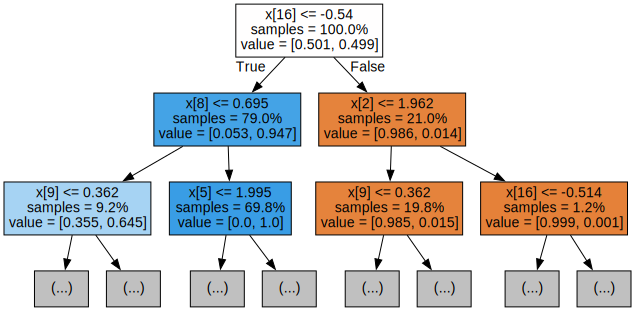

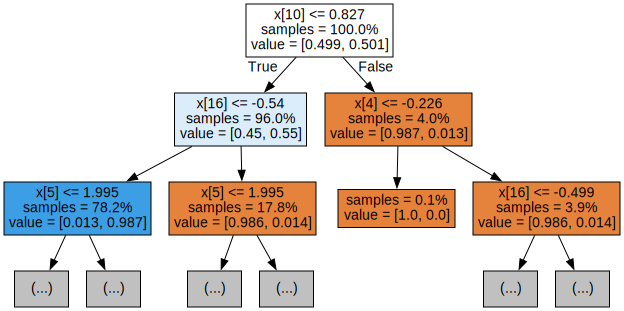

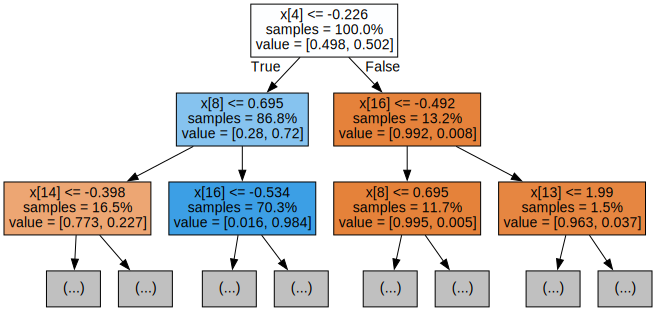

In [8]:
# Export the first three decision trees from the forest
features = np.genfromtxt('../data/medical_regular_data.csv', dtype='str', max_rows=1, delimiter=',')[:-1]
print(features)
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               #feature_names=features,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [338]:
scheme_metrics["Accuracy"].append(accuracy)
scheme_metrics["Precision"].append(precision)
scheme_metrics["Recall"].append(recall)
scheme_metrics["F1 score"].append(f1)

In [339]:
if False:
    x = np.arange(len(scheme))  # the label locations
    x *= 2
    width = 0.3  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10,15))

    for attribute, measurement in scheme_metrics.items():
        print(attribute, measurement)
        offset = width * multiplier
        #if ((multiplier + 1) // 4)==0:

        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=10)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('RF metrics')
    ax.set_title('Metrics of RF prediction by scheme W/ SMOTE')
    ax.set_xticks(x + width, scheme)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.05)


    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
    plt.show()